# # Ethiopian Bank Reviews - Task 1: Data Collection
# 
# **Objective**: Scrape and preprocess Google Play Store reviews for 3 Ethiopian banks
# 
# Banks:
# - Commercial Bank of Ethiopia (CBE)
# - Bank of Abyssinia (BOA)
# - Dashen Bank

In [5]:
# Import required modules
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import logging  # Ensure this import is present

# Ensure the parent directory of 'src' is in the Python path
sys.path.append(os.path.abspath('../'))

# Import from your modules
from src.data_collection.scraper import BankReviewScraper
from src.data_collection.preprocessor import ReviewPreprocessor
from config.settings import BANKS

In [6]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [7]:
# Initialize components
scraper = BankReviewScraper()
preprocessor = ReviewPreprocessor()

### 1. Scrape Raw Reviews

In [8]:
# Scrape each bank's reviews
raw_reviews = {}
for bank_name, app_id in BANKS.items():
    logger.info(f"Scraping {bank_name}...")
    try:
        reviews = scraper.scrape_bank(app_id, bank_name)
        raw_reviews[bank_name] = reviews
        logger.info(f"✅ Successfully scraped {len(reviews)} reviews")
    except Exception as e:
        logger.error(f"❌ Failed to scrape {bank_name}: {str(e)}")
        continue

INFO:__main__:Scraping Commercial Bank of Ethiopia...
Scraping Commercial Bank of Ethiopia:  60%|██████    | 300/500 [00:11<00:07, 26.13it/s]
INFO:__main__:✅ Successfully scraped 300 reviews
INFO:__main__:Scraping Bank of Abyssinia...
Scraping Bank of Abyssinia:  60%|██████    | 300/500 [00:08<00:05, 34.56it/s] 
INFO:__main__:✅ Successfully scraped 300 reviews
INFO:__main__:Scraping Dashen Bank...
Scraping Dashen Bank:  60%|██████    | 300/500 [00:09<00:06, 31.88it/s]
INFO:__main__:✅ Successfully scraped 300 reviews


In [9]:
# Preview raw data structure
if raw_reviews:
    sample_bank = list(raw_reviews.keys())[0]
    print(f"\nSample review structure from {sample_bank}:")
    print(raw_reviews[sample_bank][0])


Sample review structure from Commercial Bank of Ethiopia:
{'reviewId': 'b12d0383-9b27-4e49-a94d-277a43b15800', 'userName': 'Yesuf Ahmed', 'userImage': 'https://play-lh.googleusercontent.com/a/ACg8ocKGPQACprQ8i86KsvFIip9JVo_DJt7Cn1txAGLmBub8N7WzfVc=mo', 'content': 'the app is proactive and a good connections.', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': '5.1.0', 'at': datetime.datetime(2025, 6, 5, 15, 55, 10), 'replyContent': None, 'repliedAt': None, 'appVersion': '5.1.0'}


### 2. Clean and Preprocess Data

In [10]:
# Process each bank's data
clean_dfs = []
for bank_name, reviews in raw_reviews.items():
    try:
        clean_df = preprocessor.clean_data(reviews, bank_name)
        clean_dfs.append(clean_df)
        logger.info(f"✅ Processed {len(clean_df)} {bank_name} reviews")
    except Exception as e:
        logger.error(f"❌ Failed to process {bank_name}: {str(e)}")
        continue


INFO:__main__:✅ Processed 180 Commercial Bank of Ethiopia reviews
INFO:__main__:✅ Processed 195 Bank of Abyssinia reviews
INFO:__main__:✅ Processed 235 Dashen Bank reviews


In [12]:
# Combine all bank data
if clean_dfs:
    combined_df = pd.concat(clean_dfs, ignore_index=True)
    print("\nCombined dataset preview:")
    display(combined_df.head(3))
    
    # Basic stats
    print("\n📊 Data Summary:")
    print(f"Total reviews: {len(combined_df)}")
    print("\nReviews per bank:")
    print(combined_df['bank'].value_counts())


Combined dataset preview:


,review_id,review,rating,date,bank,source
0,77db45e9bb9e610a42cd16c8560ce6fd,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play
1,2c15634273c8f9922f7a870ce877a8fc,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,e8efe612c2b176fef3efdcf7955e2a9d,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play



📊 Data Summary:
Total reviews: 610

Reviews per bank:
bank
Dashen Bank                    235
Bank of Abyssinia              195
Commercial Bank of Ethiopia    180
Name: count, dtype: int64


### 3. Save Processed Data

In [13]:
# Save to files
output_dir = Path("data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

if clean_dfs:
    # Save individual bank files
    for df in clean_dfs:
        bank_name = df['bank'].iloc[0]
        filename = output_dir / f"{bank_name.lower().replace(' ', '_')}_clean.csv"
        df.to_csv(filename, index=False)
        print(f"Saved {len(df)} reviews to {filename}")
    
    # Save combined file
    combined_path = output_dir / "all_banks_combined.csv"
    combined_df.to_csv(combined_path, index=False)
    print(f"\nSaved combined data to {combined_path}")

Saved 180 reviews to data\processed\commercial_bank_of_ethiopia_clean.csv
Saved 195 reviews to data\processed\bank_of_abyssinia_clean.csv
Saved 235 reviews to data\processed\dashen_bank_clean.csv

Saved combined data to data\processed\all_banks_combined.csv


### 4. Preliminary Analysis

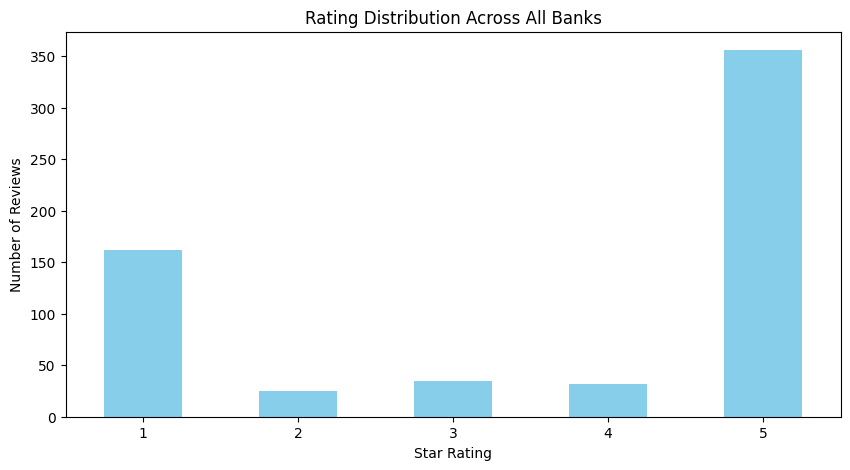

C:\Users\Amdemichael\AppData\Local\Temp\ipykernel_14200\2596827804.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df.set_index('date').resample('M')['review'].count().plot()


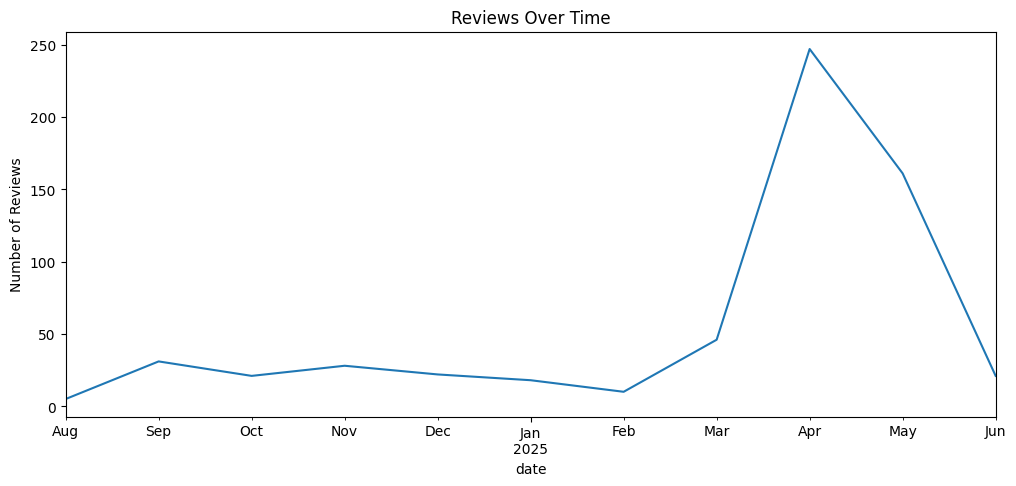

In [14]:
if not clean_dfs:
    raise ValueError("No data available for analysis")

# Rating distribution
plt.figure(figsize=(10, 5))
combined_df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution Across All Banks')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

# %%
# Reviews over time (if date column exists)
if 'date' in combined_df.columns:
    plt.figure(figsize=(12, 5))
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    combined_df.set_index('date').resample('M')['review'].count().plot()
    plt.title('Reviews Over Time')
    plt.ylabel('Number of Reviews')
    plt.show()

### 5. Data Quality Check

In [15]:
def check_data_quality(df):
    """Generate data quality report"""
    report = {
        "total_reviews": len(df),
        "missing_reviews": df['review'].isna().sum(),
        "missing_ratings": df['rating'].isna().sum(),
        "duplicates": df.duplicated(subset=['review', 'bank']).sum(),
        "short_reviews": (df['review'].str.len() < 10).sum()
    }
    return pd.DataFrame.from_dict(report, orient='index', columns=['count'])

if not clean_dfs:
    print("No data available for quality check")
else:
    print("Data Quality Report:")
    display(check_data_quality(combined_df))

Data Quality Report:


,count
total_reviews,610
missing_reviews,0
missing_ratings,0
duplicates,4
short_reviews,0
